In [1]:
"""
cmb_compare.py

Computes and plots the CMB TT power spectrum for:
 - a baseline Planck-like cosmology
 - Universe A: higher H0
 - Universe B: higher baryon density (omega_b h^2)

Requires: camb, numpy, matplotlib, astropy
"""

'\ncmb_compare.py\n\nComputes and plots the CMB TT power spectrum for:\n - a baseline Planck-like cosmology\n - Universe A: higher H0\n - Universe B: higher baryon density (omega_b h^2)\n\nRequires: camb, numpy, matplotlib, astropy\n'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import camb
from camb import model, initialpower
from astropy import constants as const
from astropy import units as u



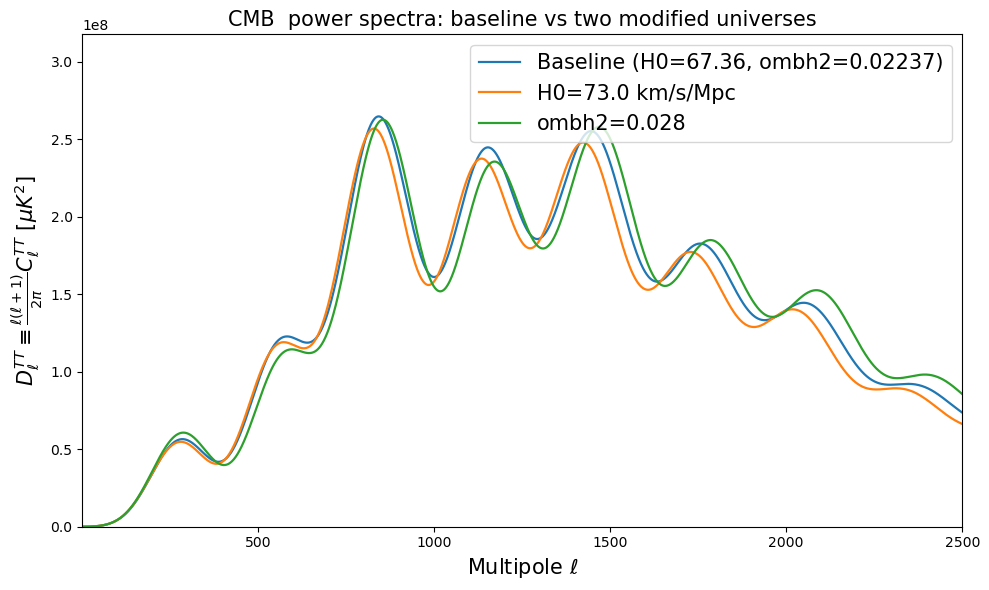

Done. Figure saved to cmb_compare.png and spectra to txt files.


In [8]:



# ----------------------------
# Helper: compute power spectrum
# ----------------------------
def get_cl_tt(H0=67.36, ombh2=0.02237, omch2=0.1200,
              As=2.1e-9, ns=0.965, tau=0.054, lmax=2500):
    """
    Return ell array and D_ell = l*(l+1) C_ell / (2pi) for TT (microK^2).
    camb returns C_ell in dimensionless units; camb's get_cmb_power_spectra returns
    Cls in units of microK^2 by default if you pass CMB units; we'll convert appropriately.
    """
    pars = camb.CAMBparams()
    pars.set_cosmology(H0=H0, ombh2=ombh2, omch2=omch2)
    pars.set_for_lmax(lmax, lens_potential_accuracy=0)
    pars.InitPower.set_params(As=As, ns=ns, r=0)
    pars.set_accuracy(AccuracyBoost=1)
    results = camb.get_results(pars)
    powers = results.get_cmb_power_spectra(pars, CMB_unit='muK')
    tt = powers['total'][:, 0]  # index 0 is TT
    ell = np.arange(tt.shape[0])
    # convert to D_l = ell (ell+1) C_ell / (2pi)
    Dl = ell * (ell + 1) * tt / (2 * np.pi)
    return ell, Dl

# ----------------------------
# Baseline (Planck-ish) params
# ----------------------------
planck_params = {
    'H0': 67.36,
    'ombh2': 0.02237,
    'omch2': 0.1200,
    'As': 2.1e-9,
    'ns': 0.9649,
    'tau': 0.0544
}

# Modified universes:
# 1) Higher H0 (shrinks angular diameter distance to last scattering -> peaks move to higher ell)
uni_high_H0 = planck_params.copy()
uni_high_H0['H0'] = 73.0  # example local measurement value

# 2) Higher baryon density (increases odd peak heights relative to even)
uni_high_ombh2 = planck_params.copy()
uni_high_ombh2['ombh2'] = 0.028  # significantly larger baryon density

# compute spectra
lmax = 2500
ell_base, Dl_base = get_cl_tt(lmax=lmax, **planck_params)
ell_h, Dl_h = get_cl_tt(lmax=lmax, **uni_high_H0)
ell_b, Dl_b = get_cl_tt(lmax=lmax, **uni_high_ombh2)

# ----------------------------
# Plot
# ----------------------------
plt.figure(figsize=(10,6))
# plot baseline
plt.plot(ell_base[2:], Dl_base[2:], label=f'Baseline (H0={planck_params["H0"]}, ombh2={planck_params["ombh2"]})', lw=1.6)
# higher H0
plt.plot(ell_h[2:], Dl_h[2:], label=f'H0={uni_high_H0["H0"]} km/s/Mpc', lw=1.6)
# higher baryon density
plt.plot(ell_b[2:], Dl_b[2:], label=f'ombh2={uni_high_ombh2["ombh2"]}', lw=1.6)

plt.xlim(2, 2500)
plt.ylim(-10, np.max(Dl_base[2:])*1.2, )
plt.xlabel(r'Multipole $\ell$', size=15)
plt.ylabel(r'$D_\ell^{TT} \equiv \frac{\ell(\ell+1)}{2\pi}C_\ell^{TT}$ [$\mu K^2$]', size=15)
plt.title('CMB  power spectra: baseline vs two modified universes', size=15)
plt.legend(loc='upper right', fontsize=15)

plt.tight_layout()
plt.savefig('cmb_compare.png', dpi=200)
plt.show()

# Also save spectra to text for inspection
np.savetxt('cmb_spectra_baseline.txt', np.column_stack([ell_base, Dl_base]), header='ell D_ell_baseline')
np.savetxt('cmb_spectra_highH0.txt', np.column_stack([ell_h, Dl_h]), header='ell D_ell_highH0')
np.savetxt('cmb_spectra_highombh2.txt', np.column_stack([ell_b, Dl_b]), header='ell D_ell_highombh2')

print("Done. Figure saved to cmb_compare.png and spectra to txt files.")


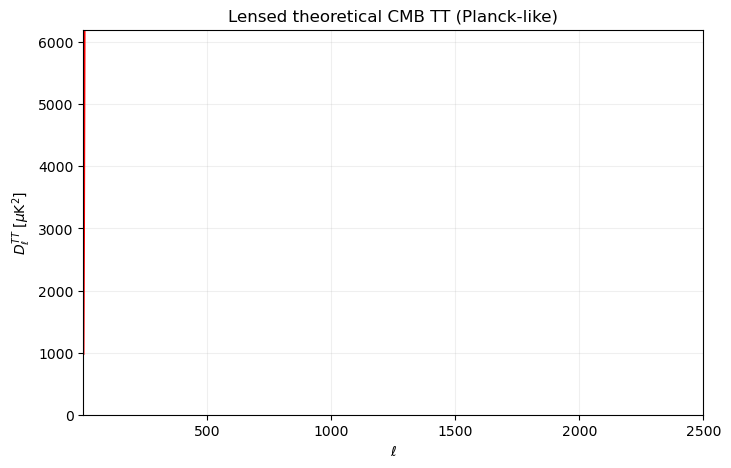

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import camb

def get_Dl_tt(H0=67.36, ombh2=0.02237, omch2=0.1200,
              As=2.1e-9, ns=0.9649, lmax=2500, lensed=True):
    pars = camb.CAMBparams()
    pars.set_cosmology(H0=H0, ombh2=ombh2, omch2=omch2)
    pars.InitPower.set_params(As=As, ns=ns)
    pars.set_for_lmax(lmax, lens_potential_accuracy=0)
    results = camb.get_results(pars)
    # choose lensed 'total' (matches Planck), or 'unlensed_scalar' if you want unlensed
    key = 'total' if lensed else 'unlensed_scalar'
    powers = results.get_cmb_power_spectra(pars, CMB_unit='muK')
    tt = powers[key][:, 0]   # index 0 -> TT
    ell = np.arange(tt.size)
    Dl = ell * (ell + 1) * tt / (2.0 * np.pi)
    return ell, Dl

# baseline Planck-like
ell, Dl = get_Dl_tt()
# plotting (skip ell=0,1)
plt.figure(figsize=(8,5))
plt.plot(ell[2:], Dl[2:], color='red', lw=1.6)
plt.xlim(2, 2500)
plt.ylim(0, 6200)
plt.xlabel(r'$\ell$')
plt.ylabel(r'$D_\ell^{TT} \; [\mu{\rm K}^2]$')
plt.title('Lensed theoretical CMB TT (Planck-like)')
plt.grid(alpha=0.2)
plt.show()
